In [1]:
import torch
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")
from torch import nn, optim
from torch.nn import functional as F
from src.datasets.dataset_wrappers import AugRepresentationDataset
from IPython.display import display,clear_output
import tqdm
from sklearn.metrics import normalized_mutual_info_score as nmi
import umap

In [2]:
#import the data
org = torch.load("../originals.pt")
aug = torch.load("../augmentations.pt")
labels = torch.load("../labels.pt")
nn_indices = torch.load("../nn_indices.pt")
dataset = AugRepresentationDataset(aug,org,labels)
org_norm = F.normalize(org,p=2,dim=-1)


In [7]:
reducer = umap.UMAP(n_components=2,random_state=42,metric="cosine")
emb = reducer.fit_transform(org)

/home/alex/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [127]:

class FuzzyConstructor(nn.Module):
    """
    A model to compute a pairwise likeness matrix using a single
    scaled dot-product attention mechanism.

    This model computes the relationship between every pair of n input
    representations without creating n*n pairs explicitly. It outputs a
    matrix of logits suitable for a pairwise binary classification task.
    """
    def __init__(self, d_model=512, nhead=16):
        """
        Args:
            d_model (int): The feature dimension of the input representations (e.g., 512).
            nhead (int): The number of attention heads. d_model must be divisible by nhead.
        """
        super().__init__()

        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        if self.head_dim * nhead != self.d_model:
            raise ValueError("d_model must be divisible by nhead")

        # Linear projections for Query and Key
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)

        # Scaling factor for dot-product attention
        self.scale = self.head_dim ** -0.5

    def forward(self, src):
        """
        Forward pass to compute the pairwise likeness matrix.

        Args:
            src (torch.Tensor): A tensor of n representations, shape (n, d_model).

        Returns:
            torch.Tensor: An (n, n) matrix of raw likeness scores (logits).
        """
        # Add a batch dimension of 1 for consistent processing
        # Input shape: (n, d_model) -> (1, n, d_model)
        src_batched = src.unsqueeze(0)
        n = src.shape[0]

        # Project the representations into Query and Key vectors
        # Input shape: (1, n, d_model)
        q = self.q_proj(src_batched)
        k = self.k_proj(src_batched)

        # Reshape for multi-head attention calculation
        # Shape: (1, n, d_model) -> (1, n, nhead, head_dim) -> (1, nhead, n, head_dim)
        q = q.view(1, n, self.nhead, self.head_dim).transpose(1, 2)
        k = k.view(1, n, self.nhead, self.head_dim).transpose(1, 2)

        # Perform scaled dot-product attention
        # (1, nhead, n, head_dim) @ (1, nhead, head_dim, n) -> (1, nhead, n, n)
        attn_scores = (q @ k.transpose(-2, -1)) * self.scale

        # Average the scores across all heads to get a single likeness matrix
        # Shape: (1, nhead, n, n) -> (1, n, n)
        likeness_matrix = attn_scores.mean(dim=1)

        # Remove the batch dimension
        # Shape: (1, n, n) -> (n, n)
        return likeness_matrix.squeeze(0)


class PairwiseAttention(nn.Module):
    def __init__(self, d_model, nhead, d_ffn=2048, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        if self.head_dim * nhead != self.d_model:
            raise ValueError("d_model must be divisible by nhead")

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ffn),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ffn, d_model)
        )
        
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Linear(d_model, d_model)
        self.scale = self.head_dim ** -0.5

    def forward(self, src):
        # Add residual connection and layer normalization
        refined_src = self.norm(src + self.dropout(self.feed_forward(src)))
        
        src_batched = refined_src.unsqueeze(0)
        n = src.shape[0]

        q = self.projection(src_batched)
        k = self.projection(src_batched)

        q = q.view(1, n, self.nhead, self.head_dim).transpose(1, 2)
        k = k.view(1, n, self.nhead, self.head_dim).transpose(1, 2)

        attn_scores = (q @ k.transpose(-2, -1)) * self.scale
        likeness_matrix = attn_scores.mean(dim=1)

        return likeness_matrix.squeeze(0)



In [167]:
model = FuzzyConstructor()
device = 'cuda'
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([100]))
model.train()

FuzzyConstructor(
  (q_proj): Linear(in_features=512, out_features=512, bias=True)
  (k_proj): Linear(in_features=512, out_features=512, bias=True)
)

In [200]:
losses = []
num_negative = 50
pos_losses = []
neg_losses = []
dataloader = DataLoader(dataset,batch_size=500,shuffle=True)
progress_bar = tqdm.notebook.trange(50)
for epoch in progress_bar:
    for batch in dataloader:
        
        x1,x2,x,y = batch
        n,d = x1.shape
        targets = torch.zeros(n,n)
        targets[torch.eye(n).bool()] = 1

        # The target matrix is [[0, I], [I, 0]]
        # where I is the n x n identity matrix.
        identity_n = torch.eye(n, device=device)
        
        top_row = torch.cat([identity_n, identity_n], dim=1)
        bottom_row = torch.cat([identity_n, identity_n], dim=1)
        targets = torch.cat([top_row, bottom_row], dim=0).to(device)


        # Concatenate the two sets of augmentations
        X = torch.cat([x, x2], dim=0).to(device)
        
        # --- Model Prediction and Loss ---
        pred_logits = model(X)
        
        # Use BCEWithLogitsLoss for numerical stability
        criterion = nn.BCEWithLogitsLoss()
        
        loss = criterion(pred_logits, targets)

        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    progress_bar.set_description(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")
        

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [201]:
#get the off diag positives
like_samples = targets.clone()
like_samples[torch.eye(2*n).bool()] = 0

F.sigmoid(pred_logits[targets.bool()]).mean(),F.sigmoid(pred_logits[~targets.bool()]).mean()

(tensor(0.5328, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward0>))

In [216]:
X_norm = F.normalize(X,p=2,dim=-1)
sims = X_norm @ X_norm.T

<Axes: >

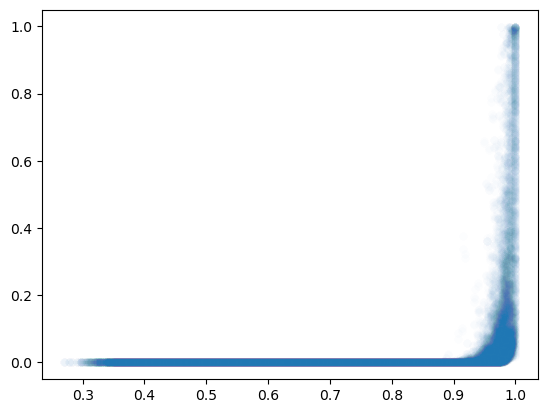

In [204]:
sns.scatterplot(x=sims.flatten().detach().cpu().numpy(),y=F.sigmoid(pred_logits).flatten().detach().cpu().numpy(),alpha=0.01)

In [217]:
p = pred_logits.detach().cpu()
psort = torch.argsort(p,dim=1,descending=True)
simsort = torch.argsort(sims,dim=1,descending=True).cpu().detach()

In [218]:
Y = torch.cat([y,y],dim=0)
psort.shape

torch.Size([1000, 1000])

In [219]:
psort

tensor([[  0, 500, 690,  ..., 928, 428,  20],
        [  1,   2, 501,  ..., 199, 264, 251],
        [  2,   1, 836,  ..., 251, 264, 199],
        ...,
        [997, 654, 534,  ...,  70, 300, 453],
        [998, 877, 854,  ..., 298, 543,  70],
        [999, 499, 686,  ...,  89, 300, 272]])

In [224]:
k=500
(Y[psort][:,k:] == Y.unsqueeze(1)).sum()/(Y.shape[0]*k),(Y[simsort][:,k:] == Y.unsqueeze(1)).sum()/(Y.shape[0]*k)

(tensor(0.0100), tensor(0.0052))

tensor(80)

tensor([0, 0, 4, 9, 1, 8, 8, 0, 3, 0, 9, 8, 0, 9, 6, 1, 6, 5, 5, 5, 4, 9, 1, 8,
        4, 0, 8, 2, 1, 0, 6, 2, 0, 8, 0, 6, 8, 2, 6, 0, 8, 8, 4, 3, 0, 5, 0, 4,
        4, 5, 2, 6, 1, 1, 9, 9, 8, 9, 9, 0, 1, 0, 9, 8, 8, 9, 8, 1, 2, 6, 0, 9,
        9, 9, 0, 8, 8, 2, 8, 7, 9, 9, 4, 8, 8, 2, 7, 2, 8, 6, 0, 4, 9, 5, 5, 4,
        9, 3, 5, 0, 0, 6, 9, 4, 4, 2, 1, 0, 0, 3, 5, 3, 0, 4, 2, 2, 8, 6, 2, 6,
        9, 0, 7, 4, 9, 6, 6, 0, 5, 8, 1, 3, 8, 8, 9, 9, 1, 2, 0, 9, 0, 6, 7, 9,
        0, 2, 1, 5, 8, 1, 8, 7, 9, 5, 1, 6, 8, 0, 9, 1, 0, 0, 8, 9, 6, 0, 9, 8,
        5, 8, 3, 1, 8, 8, 3, 1, 1, 6, 1, 4, 9, 6, 2, 2, 3, 8, 9, 4, 4, 2, 4, 9,
        0, 0, 5, 0, 2, 1, 2, 5, 6, 8, 6, 1, 5, 3, 4, 5, 4, 7, 7, 5, 4, 9, 0, 0,
        5, 9, 9, 8, 0, 5, 7, 8, 0, 9, 9, 0, 9, 9, 4, 2, 2, 8, 5, 6, 0, 6, 2, 3,
        8, 3, 8, 3, 2, 8, 9, 8, 6, 5, 9, 6, 6, 5, 0, 0, 4, 0, 6, 8, 1, 9, 8, 2,
        5, 8, 5, 9, 6, 0, 2, 6, 6, 9, 2, 4, 9, 9, 8, 4, 0, 7, 0, 2, 0, 0, 1, 9,
        1, 1, 5, 2, 8, 5, 9, 5, 8, 5, 8,